--- 
title: PA 8.1
author: Isabelle Antaran
format:
    html:
        toc: true
        code-fold: true
        embed-resources: true
theme: flatly
---

# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `bill_depth_mm` using the other variables in the dataset.

**Dummify** all variables that require this.

In [34]:
import pandas as pd
import numpy as np

from palmerpenguins import load_penguins

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import plotnine as p9

In [35]:
penguins = load_penguins()
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


In [36]:
penguins = penguins.dropna()

In [37]:
X = penguins.drop("bill_depth_mm", axis=1)
y = penguins["bill_depth_mm"]

In [38]:
X = pd.get_dummies(X, drop_first=True)

In [39]:
penguins.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
count,333.000000,333.000000,333.000000,333.000000,333.000000
mean,43.992793,17.164865,200.966967,4207.057057,2008.042042
std,5.468668,1.969235,14.015765,805.215802,0.812944
min,32.100000,13.100000,172.000000,2700.000000,2007.000000
25%,39.500000,15.600000,190.000000,3550.000000,2007.000000
50%,44.500000,17.300000,197.000000,4050.000000,2008.000000
75%,48.600000,18.700000,213.000000,4775.000000,2009.000000
max,59.600000,21.500000,231.000000,6300.000000,2009.000000


Let's use the other variables to predict `bill_depth_mm`. Prepare your data and fit the following models on the entire dataset:

* Your best multiple linear regression model from before
* Two kNN models (for different values of K)
* A decision tree model

Create a plot like the right plot of Fig 1. in our `Model Validation` chapter with the training and test error plotted for each of your four models.

Which of your models was best?

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [41]:
numeric_features = X.select_dtypes(include=np.number).columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)
    ],
    remainder='passthrough'
)

In [42]:
# Multiple Linear Regression
lr_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', LinearRegression())])

# kNN Model (K=3)
knn3_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', KNeighborsRegressor(n_neighbors=3))])

# kNN Model (K=5)
knn5_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', KNeighborsRegressor(n_neighbors=5))])

# Decision Tree Model
tree_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', DecisionTreeRegressor(ccp_alpha = 0.5))])

In [43]:
models = {
    "Linear Regression": lr_pipe,
    "kNN (K=3)": knn3_pipe,
    "kNN (K=5)": knn5_pipe,
    "Decision Tree": tree_pipe
}

results = []

In [44]:
for name, model in models.items():
    # Fit model
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate RMSE
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    results.append({"Model": name, "Training RMSE": train_rmse, "Test RMSE": test_rmse})

In [45]:
results_df = pd.DataFrame(results)
print("Model Performance:")
results_df

Model Performance:


,Model,Training RMSE,Test RMSE
0,Linear Regression,0.732354,0.901417
1,kNN (K=3),0.589409,0.918735
2,kNN (K=5),0.652796,0.883855
3,Decision Tree,1.083551,1.218738


In [49]:
plot_df = results_df.melt(id_vars='Model', var_name='Error Type', value_name='RMSE')

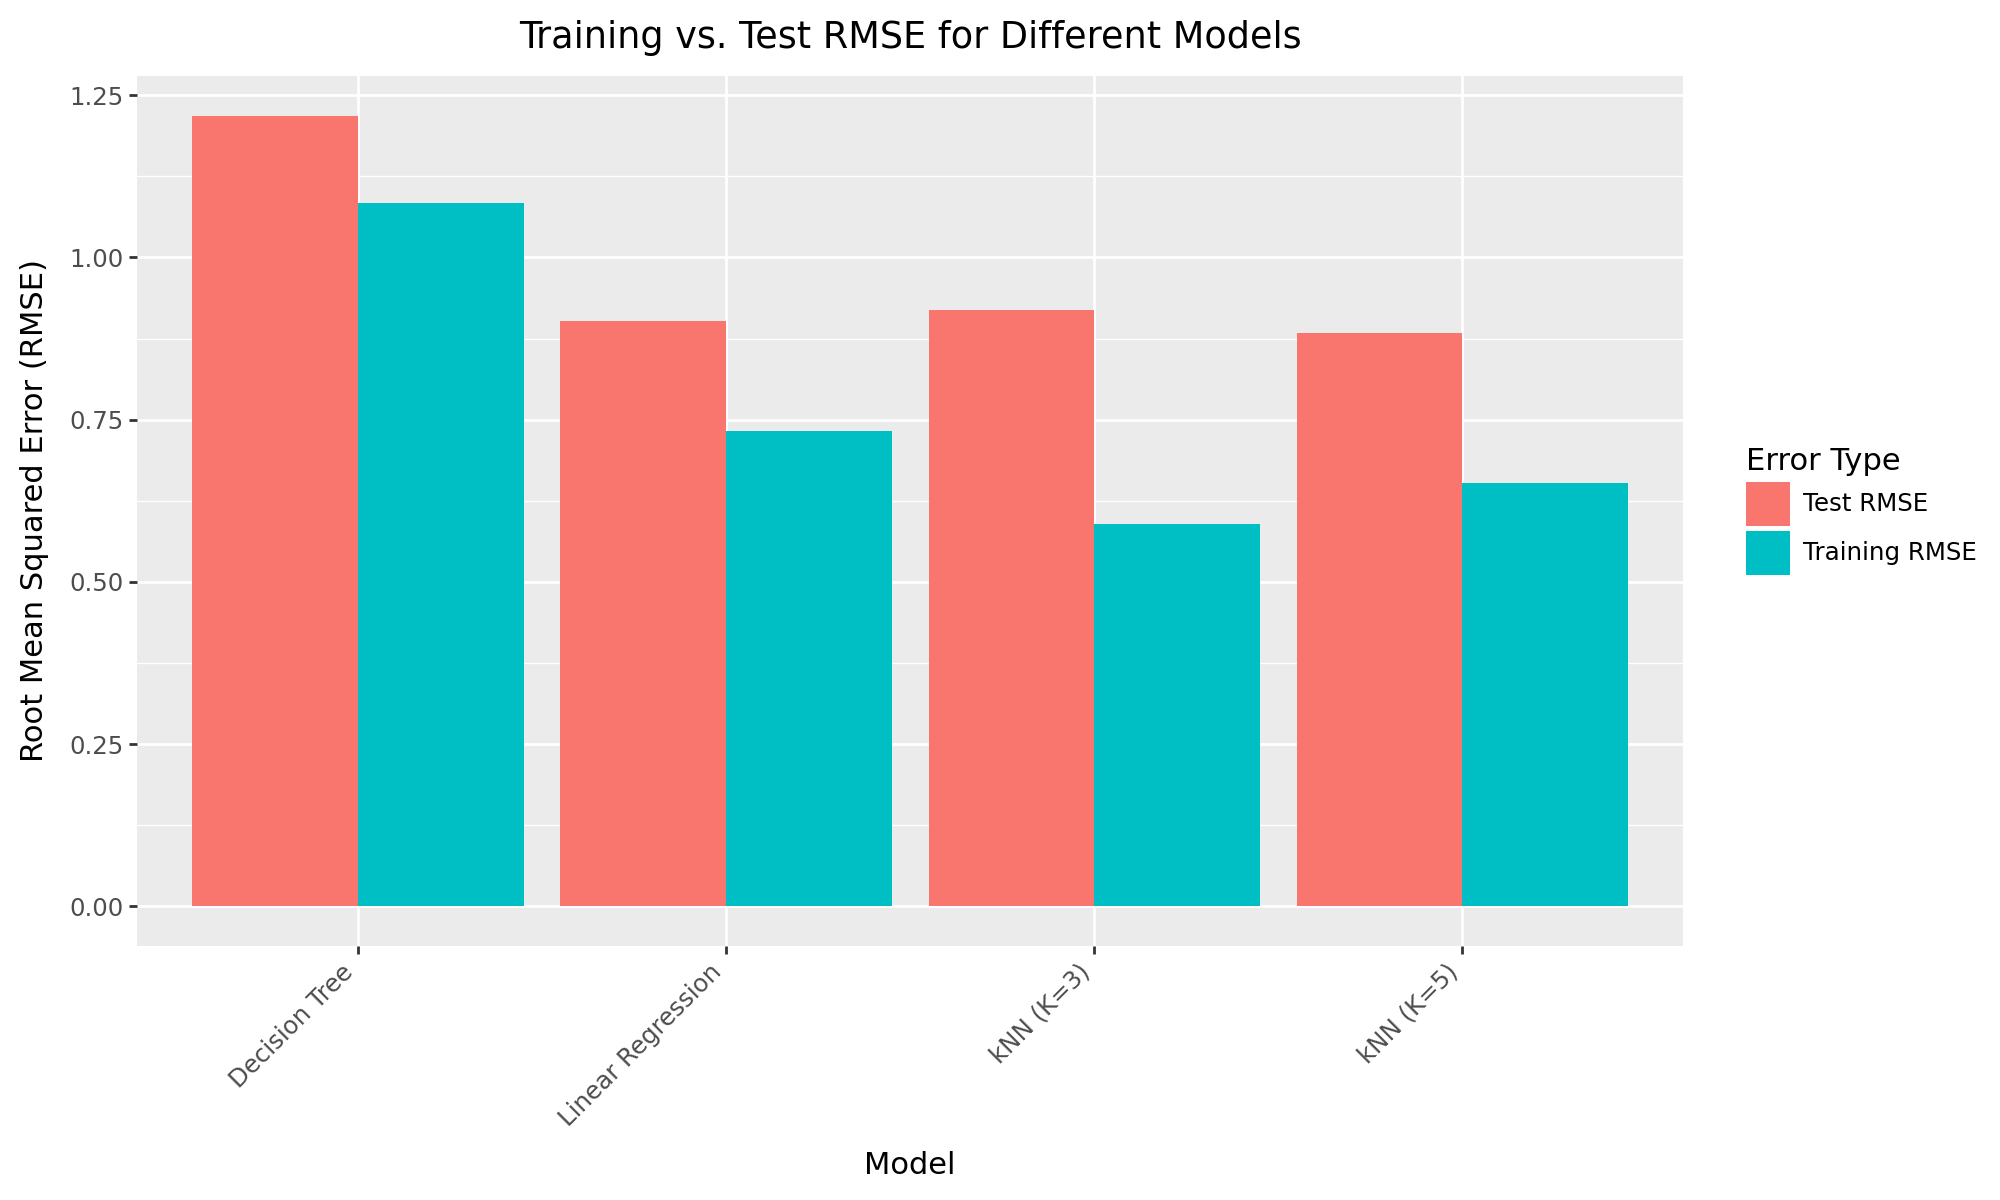

In [ ]:
plot = (
    p9.ggplot(plot_df, p9.aes(x='Model', y='RMSE', fill='Error Type'))
    + p9.geom_col(position='dodge')
    + p9.labs(
        title='Training vs. Test RMSE for Different Models',
        y='Root Mean Squared Error (RMSE)',
        x='Model'
    )
    + p9.theme(
        figure_size = (10, 6),
        axis_text_x = p9.element_text(rotation=45, ha='right')
    )
)
plot.show()

In [55]:
# Analysis: Model Comparison
print(f"Best Training Performance: {results_df.loc[results_df['Training RMSE'].idxmin(), 'Model']}")
print(f"Training RMSE: {results_df['Training RMSE'].min():.4f}")
print(f"Best Test Performance: {results_df.loc[results_df['Test RMSE'].idxmin(), 'Model']}")
print(f"Test RMSE: {results_df['Test RMSE'].min():.4f}")

Best Training Performance: kNN (K=3)
Training RMSE: 0.5894
Best Test Performance: kNN (K=5)
Test RMSE: 0.8839


In [56]:
print(f"Best Overall Model: kNN (K=5) with lowest test RMSE of {results_df['Test RMSE'].min():.4f}")

Best Overall Model: kNN (K=5) with lowest test RMSE of 0.8839
